In [26]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import collections
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [62]:
def combine_feature(players,score,pitch_array,energy_array ):
    player_list = []
    score_list = []
    pitch_list = []
    timestamp_list = []
    for k, v in players.reshape(1,-1)[0][0].items():
        timestamp_list.append(k)
        player_list.append(v)
#         player_list = smooth(player_list,4)
    for k, v in score.reshape(1,-1)[0][0].items():
        score_list.append(v)
#         score_list = smooth(score_list,4)
#     for k, v in pitch_array.reshape(1,-1)[0][0].items():
#         pitch_list.append(v)
    print(len(player_list), len(score_list), len(timestamp_list))
#     combine1 = np.column_stack((score_list, pitch_array))
    combine2 = np.column_stack((score_list, player_list))
    combine3 = np.column_stack((combine2, energy_array))
    print(combine3.shape)
    normalized = normalize(combine3, axis=0, norm='max')
    return normalized,timestamp_list,player_list,score_list, pitch_array,energy_array

def create_labels(metadata,all_timestamp ):
    highlihgts_benchmark = metadata[2].tolist()[1:]
    training_label = np.zeros((len(all_timestamp)))
    for index,timestamp in enumerate(all_timestamp):
        template = "%Y-%m-%dT%H:%M:%S"
        timestamp = datetime.strptime(timestamp, template)
        timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")
        if any(timestamp in s for s in highlihgts_benchmark):
            label = 1
        else:
            label = 0
        training_label[index] = label
    label = training_label.astype(int)
#     print('length of training label:', len(label),'number of highlights:',np.count_nonzero(label))
    print('length of test label:', len(label),'number of highlights:',np.count_nonzero(label))
    return label
def smooth(x,beta):
    window_len=11
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

In [63]:
score_d1 = np.load('score_dict_d1.npy')
pitch_d1 = np.load('pitch_processed_d1.npy')
players_d1 = np.load('numberofplayers_forP1_P6.npy')
energy_d1 = np.load('energy_processed_d1.npy')

score_d2 = np.load('score_dict_d2.npy')
pitch_d2 = np.load('pitch_processed_d2.npy')
players_d2 = np.load('numberofplayers_forP7_P11.npy')
energy_d2 = np.load('energy_processed_d2.npy')

training_metadata = pd.read_csv('metadata_03_02.csv', sep=',',header=None)
test_metadata = pd.read_csv('metadata_03_04.csv', sep=',',header=None)

**For training**

In [64]:
training_set,training_timestamp,player_list_d1,score_list_d1, pitch_list_d1,energy_array_d1  = combine_feature(
    players_d1,score_d1,pitch_d1,energy_d1 )

30305 30305 30305
(30305, 3)


**For Testing**

In [65]:
test_set,test_timestamp,player_list_d2,score_list_d2, pitch_list_d2,energy_array_d2 = combine_feature(
    players_d2,score_d2,pitch_d2,energy_d2 )

24493 24493 24493
(24493, 3)


** Now I create labels for training and testing **

In [58]:
training_label = create_labels(training_metadata,training_timestamp )

length of test label: 30305 number of highlights: 25


In [59]:
test_label = create_labels(test_metadata,test_timestamp )

length of test label: 24493 number of highlights: 25


In [66]:
sm = SMOTE(random_state=20)
import random
X_res, y_res = sm.fit_sample(training_set, training_label)
print('Original dataset shape {}'.format(collections.Counter(training_label)))
print('Resampled dataset shape {}'.format(collections.Counter(y_res)))

Original dataset shape Counter({0: 30280, 1: 25})
Resampled dataset shape Counter({0: 30280, 1: 30280})


[0.9533355350066051, 0.9464332892998678, 0.9449306472919419, 0.9432133421400263, 0.9370211360634082, 0.9370706737120212, 0.931902245706737, 0.9321169088507265, 0.9275924702774109, 0.9276750330250991, 0.9238441215323647, 0.9236955085865256, 0.9194517833553502, 0.9200957727873182, 0.9166446499339498, 0.9176023778071333, 0.9141182298546895, 0.9149603698811095, 0.9123018494055483, 0.9129623513870542, 0.910386393659181, 0.9111789960369882, 0.9092140026420079, 0.9095937912813739, 0.9078104359313078, 0.9082562747688243, 0.906439894319683, 0.9069187582562748, 0.9048712021136062]


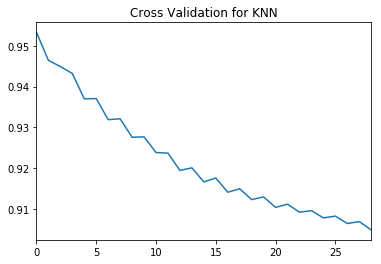

In [230]:
cv_scores=[]
for k in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_res, y_res, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)
sns.tsplot(cv_scores)
plt.title('Cross Validation for KNN')
plt.show()

In [87]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_res, y_res) 
pred_label = clf.predict(test_set)

# clf = SVC()
# clf.fit(X_res, y_res)
# pred_label = clf.predict(test_set)

# neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(X_res, y_res) 
# pred_label = neigh.predict(test_set)
TN = 0
FN = 0
FP = 0
TP = 0
for idx,label in enumerate(pred_label):
    if label ==0 and test_label[idx]==0:
        TN +=1
    if label ==0 and test_label[idx]==1:
        FN +=1
    if label ==1 and test_label[idx]==0:
        FP +=1
    if label ==1 and test_label[idx]==1:
        TP +=1
print ('TP:',TP)
print ('FP:',FP)
print ('TN:',TN)
print ('FN:',FN)
print ('precision:' ,1.0 * TP/(TP+FP))
print ('recall:' ,1.0 * TP/(TP+FN))
print('accuracy',(TP+TN)/len(test_label))

TP: 20
FP: 7087
TN: 17381
FN: 5
precision: 0.0028141269171239624
recall: 0.8
accuracy 0.7104478830686318


In [86]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_res, y_res) 
pred_label = clf.predict(training_set)

# clf = SVC()
# clf.fit(X_res, y_res)
# pred_label = clf.predict(training_set)

# neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(X_res, y_res) 
# pred_label = neigh.predict(training_set)
TN = 0
FN = 0
FP = 0
TP = 0
for idx,label in enumerate(pred_label):
    if label ==0 and training_label[idx]==0:
        TN +=1
    if label ==0 and training_label[idx]==1:
        FN +=1
    if label ==1 and training_label[idx]==0:
        FP +=1
    if label ==1 and training_label[idx]==1:
        TP +=1
print ('TP:',TP)
print ('FP:',FP)
print ('TN:',TN)
print ('FN:',FN)
print ('precision:' ,1.0 * TP/(TP+FP))
print ('recall:' ,1.0 * TP/(TP+FN))
print('accuracy',(TP+TN)/len(training_label))

TP: 21
FP: 11286
TN: 18994
FN: 4
precision: 0.0018572565667285751
recall: 0.84
accuracy 0.6274542154759941


# Visualization


In [186]:
# clf.fit(training_set, training_label)
# pred_label = clf.predict(training_set)
# np.count_nonzero(pred_label)

30305
24493


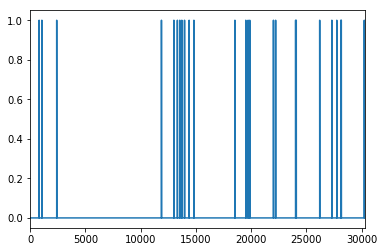

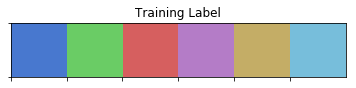

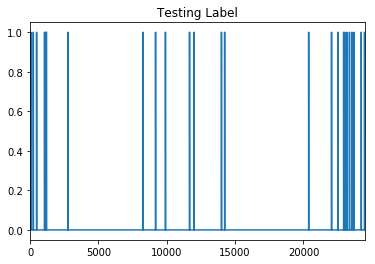

In [179]:
sns.tsplot(training_label)
plt.title('Training Label')
plt.show()
sns.tsplot(test_label)
plt.title('Testing Label')
plt.show()

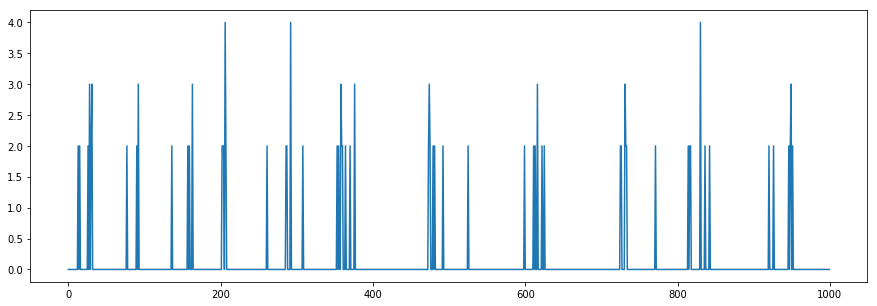

In [73]:
collections.Counter(player_list_d1)
plt.figure(figsize=(15,5))
plt.plot(player_list_d1[0:1000])
plt.show()

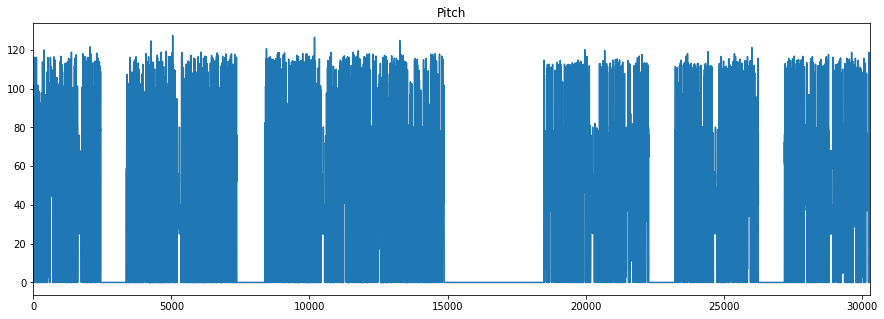

In [81]:
plt.figure(figsize=(15,5))
sns.tsplot(pitch_list_d1)
plt.title('Pitch')
plt.show()

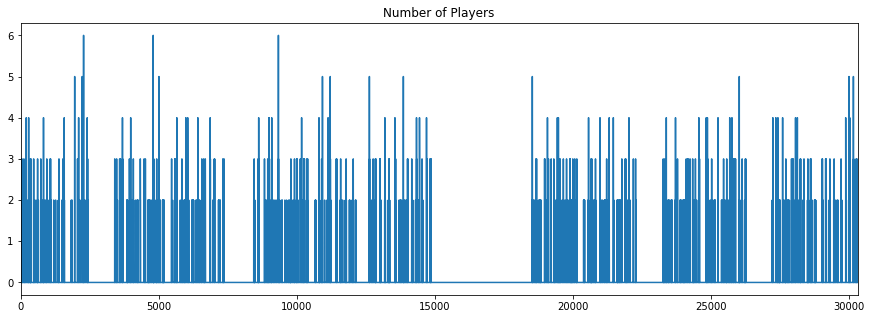

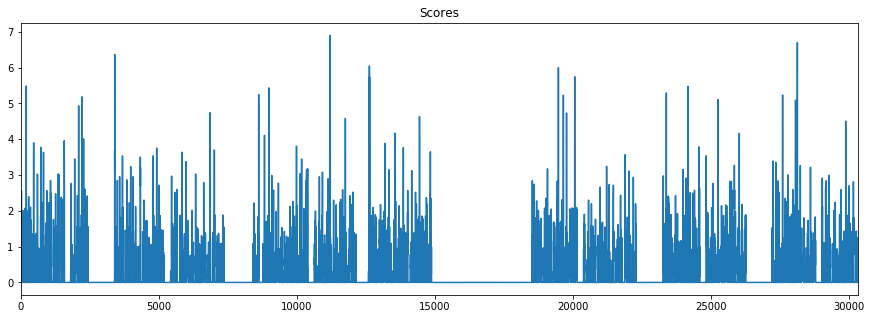

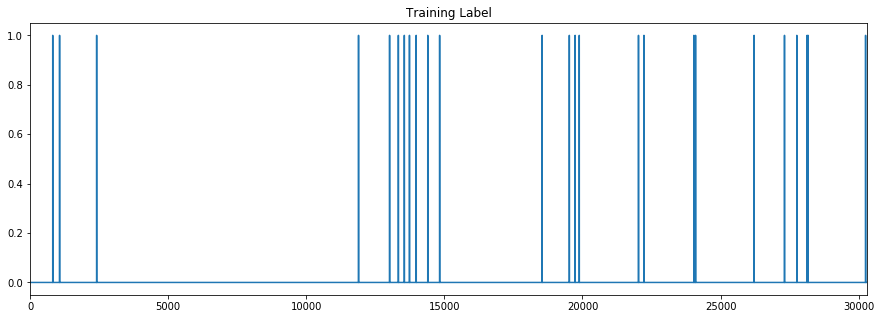

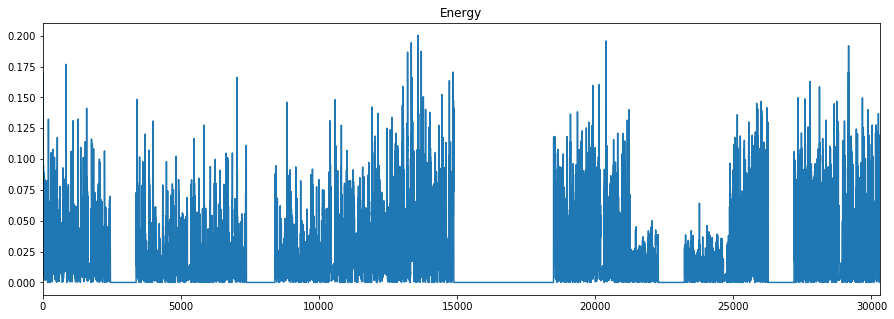

In [78]:
# player_list_d1,score_list_d1, pitch_list_d1,energy_array_d1
plt.figure(figsize=(15,5))
sns.tsplot(player_list_d1)
plt.title('Number of Players')
plt.show()
plt.figure(figsize=(15,5))
sns.tsplot(score_list_d1)
plt.title('Scores')
plt.show()
plt.figure(figsize=(15,5))
sns.tsplot(training_label)
plt.title('Training Label')
plt.show()
plt.figure(figsize=(15,5))
sns.tsplot(energy_array_d1)
plt.title('Energy')
plt.show()